In [22]:
# 🍎 Apple Quality Classification - Updated to Use Separate Validation Set

import os
import cv2
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


# ✅ 설정
IMG_SIZE = 100
DATA_DIR = ".\\cnn_yolo_resuit\\data"
MODEL_PATH = ".\\cnn_yolo_resuit\\trained_model.h5"
DEBUG_DIR = ".\\cnn_yolo_resuit\\debug_outputs"
CROPPED_DIR = ".\\cnn_yolo_resuit\\Cropped_apples"
label_map = {"보통": 0, "상": 1, "특": 2, "하": 3}
class_names = ["보통", "상", "특", "하"]
label_map_english = {"보통": "Normal", "상": "Good", "특": "Best", "하": "Reject"}

# ✅ 전처리 함수 정의 (학습 및 검증 데이터 모두에서 사용 가능)
def preprocess_data(base_path):
    apple_sizes = ["Apple_fuji_L", "Apple_fuji_M", "Apple_fuji_S"]  # 🍎 세 가지 사과 크기(L, M, S) 대상
    X, y = [], []  # 이미지와 라벨 저장 리스트

    for size in apple_sizes:  # 각 크기별로 반복
        label_dir = os.path.join(base_path, "label_data", size)  # 📁 JSON 라벨이 저장된 폴더 경로
        image_dir = os.path.join(base_path, "source_data", size)  # 📁 원본 이미지가 저장된 폴더 경로

        if not os.path.exists(label_dir):  # 폴더가 없으면 건너뜀
            continue

        for filename in os.listdir(label_dir):  # 라벨 폴더 내 모든 파일 순회
            if filename.endswith(".json"):  # .json 파일만 처리
                name = os.path.splitext(filename)[0]  # 확장자를 제외한 파일 이름 추출
                json_path = os.path.join(label_dir, filename)  # JSON 전체 경로
                image_path = os.path.join(image_dir, name + ".png")  # PNG 이미지 경로 구성

                try:
                    # ✅ JSON 파일 열기 및 라벨 추출
                    with open(json_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)

                    label_text = data.get("cate3")  # "cate3" 필드에서 등급 추출 (예: "보통", "특")
                    label = label_map.get(label_text)  # 라벨을 숫자로 매핑

                    # 🔍 예외 처리: 라벨이 없거나 이미지 파일이 존재하지 않으면 건너뜀
                    if label is None or not os.path.exists(image_path):
                        continue

                    # ✅ 이미지 읽기 및 전처리
                    img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # 이미지 로딩 (BGR)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB로 변환
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # 모델 입력 크기로 조정
                    img = img.astype("float32") / 255.0  # 0~1 정규화

                    # ✅ 학습 데이터 리스트에 추가
                    X.append(img)
                    y.append(label)

                except:
                    # 예외 발생 시 해당 샘플은 무시하고 계속 진행
                    continue

    return np.array(X), np.array(y)  # 최종적으로 NumPy 배열로 반환


In [23]:
import os

# ✅ CNN 모델 정의 (Dropout 포함)
def create_improved_cnn(input_shape=(100, 100, 3), num_classes=3):
    model = models.Sequential([
        # 1️⃣ 첫 번째 합성곱 블록 (Conv → BN → ReLU → MaxPool)
        layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),  # 3x3 필터 32개, 입력 크기 지정
        layers.BatchNormalization(),  # 배치 정규화로 학습 안정화
        layers.Activation('relu'),    # ReLU 활성화 함수
        layers.MaxPooling2D(2, 2),    # 2x2 풀링으로 다운샘플링

        # 2️⃣ 두 번째 합성곱 블록
        layers.Conv2D(64, (3, 3), padding='same'),  # 필터 수 증가
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.4),          # 과적합 방지를 위한 드롭아웃

        # 3️⃣ 세 번째 합성곱 블록
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.4),

        # 4️⃣ 분류기 레이어 (Fully Connected 대체)
        layers.GlobalAveragePooling2D(),  # GAP: 평균값으로 차원 축소
        layers.Dense(64, activation='relu'),  # 은닉층
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # 출력층: 클래스 수만큼 softmax
    ])
    
    # ✅ 모델 컴파일 (손실함수 + 옵티마이저 + 평가 지표)
    model.compile(
        optimizer='adam',  # Adam 옵티마이저 (학습 자동 조절)
        loss='sparse_categorical_crossentropy',  # 다중 클래스 분류 손실함수 (정수형 라벨 사용)
        metrics=['accuracy']  # 정확도 평가
    )
    
    return model



# ✅ 학습된 모델이 없으면 새로 학습, 있으면 불러오기
if not os.path.exists(MODEL_PATH):  # 학습 모델 파일 존재 여부 확인
    # 1️⃣ 훈련 및 검증 데이터 불러오기
    X_train, y_train = preprocess_data(os.path.join(DATA_DIR, "Training"))
    X_val, y_val = preprocess_data(os.path.join(DATA_DIR, "Validation"))

    # 데이터 증강
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(X_train)

    # 2️⃣ 클래스별 데이터 수를 기반으로 가중치 설정 (불균형 대응)
    class_counts = Counter(y_train)
    total = float(sum(class_counts.values()))
    class_weights = {i: total / class_counts[i] for i in class_counts}  # 데이터 적은 클래스에 더 큰 가중치 부여

    # 3️⃣ 모델 생성 및 조기 종료 콜백 설정
    model = create_improved_cnn()
    early_stop = EarlyStopping(
        monitor='val_loss',          # 검증 손실 기준
        patience=5,                  # 5 에폭 동안 향상 없으면 종료
        restore_best_weights=True   # 가장 좋은 가중치로 복원
    )

    # 4️⃣ 모델 학습
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32),  # 데이터 증강 적용
        validation_data=(X_val, y_val),
        epochs=30,
        steps_per_epoch=len(X_train) // 32, # steps_per_epoch 추가
        class_weight=class_weights,
        callbacks=[early_stop],
        verbose=1
    )

    # 5️⃣ 학습 완료 후 모델 저장
    model.save(MODEL_PATH)
    print(f"✅ 학습된 모델이 저장되었습니다: {MODEL_PATH}")
else:
    # ✅ 이미 학습된 모델이 있으면 로드
    model = load_model(MODEL_PATH)


Epoch 1/30


c:\Users\kim02\.cursor\apple detect\apple detect\310env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32,), dtype=float32). Expected shape (None, 100, 100, 3), but input has incompatible shape (32,)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32,), dtype=float32)
  • training=True
  • mask=None

In [24]:
import cv2
import numpy as np
import os

# ✅ 결함 여부 판단 함수 (HSV 및 대비 기반)
def is_defective(
    img, 
    index=0,  # 디버그 이미지 파일명용 인덱스
    defect_threshold_area=50,  # 결함 판단 최소 면적
    save_dir=".\cnn_yolo_resuit\debug_outputs_hsv_contrast"  # 디버그 이미지 저장 폴더
):
    os.makedirs(save_dir, exist_ok=True)  # 저장 폴더가 없으면 생성
    height, width = img.shape[:2]  # 이미지 크기 추출

    # ✅ 1단계: HSV 색공간으로 변환 후 채널 분리
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)  # 색상(H), 채도(S), 명도(V)

    # ✅ 2단계: 각 채널 기반 결함 마스크 생성
    dark_mask = cv2.inRange(v, 0, 70)       # 어두운 영역 (명도 낮음)
    low_s_mask = cv2.inRange(s, 0, 50)      # 채도 낮은 영역
    abnormal_h_mask = cv2.bitwise_or(       # 색상이 이상한 범위
        cv2.inRange(h, 0, 10), 
        cv2.inRange(h, 160, 180)
    )
    abnormal_h_mask = cv2.bitwise_or(       # 추가적으로 초록빛 계열도 결함으로 판단
        abnormal_h_mask,
        cv2.inRange(h, 30, 70)
    )

    # ✅ HSV 조건들을 하나의 마스크로 결합
    hsv_mask = cv2.bitwise_or(dark_mask, low_s_mask)
    hsv_mask = cv2.bitwise_or(hsv_mask, abnormal_h_mask)

    # ✅ 3단계: HSV 마스크가 부족하면 대비 기반 결함 추가 적용
    use_contrast = False
    hsv_contours, _ = cv2.findContours(hsv_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    significant_hsv = [cnt for cnt in hsv_contours if cv2.contourArea(cnt) >= defect_threshold_area]

    if len(significant_hsv) < 2:  # 2개 이상 결함이 안 잡히면 대비 기준 보조 적용
        use_contrast = True

    if use_contrast:
        blurred_v = cv2.GaussianBlur(v, (11, 11), 0)       # 명도 채널 흐리기
        contrast = cv2.absdiff(v, blurred_v)               # 명도 대비 마스크 생성
        contrast_mask = cv2.inRange(contrast, 40, 255)     # 급격한 대비 영역
        final_mask = cv2.bitwise_or(hsv_mask, contrast_mask)  # 기존 HSV 마스크와 결합
    else:
        final_mask = hsv_mask

    # ✅ 4단계: 결함 검출 후 경계 상자 기준 필터링
    contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered = []
    margin = int(min(height, width) * 0.1)  # 테두리 10% 영역은 무시 (오검 방지)
    debug_img = img.copy()  # 시각화용 복사 이미지

    for cnt in contours:
        x, y, w, h_box = cv2.boundingRect(cnt)
        # 너무 테두리에 가까운 건 무시
        if x < margin or y < margin or x + w > width - margin or y + h_box > height - margin:
            continue

        area = cv2.contourArea(cnt)
        if area >= defect_threshold_area:  # 최소 면적 조건 통과한 경우만 저장
            filtered.append((cnt, area))
            cv2.rectangle(debug_img, (x, y), (x + w, y + h_box), (0, 0, 255), 2)  # 빨간색 사각형

    # ✅ 5단계: 디버그 이미지 저장
    out_path = os.path.join(save_dir, f"defect_debug_{index}.png")
    cv2.imwrite(out_path, debug_img)

    # ✅ 6단계: 결함 수 기준으로 True/False 반환
    print("HSV 1차 분류 완료")
    return True if len(filtered) >= 2 else False  # 결함 2개 이상 시 결함 있는 것으로 판단


In [25]:

# 🧪 CNN 예측 및 등급 판단 함수
def predict_grade(model, img_path, index=0, debug_dir=None):
    img = cv2.imread(img_path)  # 이미지 로드
    if img is None:  # 이미지 불러오기 실패 시 하 등급 처리
        return "하", 0.0

    # 🔍 사전 결함 탐지 (결함이 많으면 바로 하로 분류)
    if is_defective(img, index=index, save_dir=debug_dir):
        return "하", 0.0

    # ✅ 전처리: RGB 변환 및 크기 조정, 정규화
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb, (IMG_SIZE, IMG_SIZE)).astype("float32") / 255.0
    input_tensor = resized.reshape(1, IMG_SIZE, IMG_SIZE, 3)

    # ✅ 예측 수행 (확률값 추출)
    pred = model.predict(input_tensor, verbose=0)[0]

    # 🔁 예측 등급 (가장 높은 확률의 클래스)
    return class_names[np.argmax(pred)], float(np.max(pred))


# ✅ 사과 이미지가 저장된 폴더 (YOLO crop 결과물)
CROPPED_DIR = "./cropped_apples"
os.makedirs(CROPPED_DIR, exist_ok=True)

# ✅ 이미지 파일 목록 정렬
image_files = sorted([
    f for f in os.listdir(CROPPED_DIR)
    if f.lower().endswith((".webp", ".jpg", ".jpeg", ".png"))
])

results = []

# 🔁 각 이미지에 대해 예측 반복
for i, fname in enumerate(image_files):
    path = os.path.join(CROPPED_DIR, fname)
    grade, conf = predict_grade(model, path, index=i, debug_dir=DEBUG_DIR)

    # 결과 저장
    results.append({"image": fname, "grade": grade, "confidence": round(conf, 4)})

# ✅ 결과를 CSV로 저장
pd.DataFrame(results).to_csv("cnn_yolo_results.csv", index=False, encoding="utf-8-sig")


# 🟡 CNN 결과를 반영하기 위한 class_id → 텍스트 변환 함수
def id_to_grade(class_id):
    return {"0": "보통", "1": "상", "2": "특", "3": "하"}.get(str(class_id), "Unknown")

# ✅ 원본 YOLO 좌표 불러오기
with open("./dataset/1_yolo.txt", 'r') as f:
    yolo_lines = f.readlines()

# ✅ CNN 결과를 적용하여 새로운 YOLO 텍스트 생성
with open("./Labeled_txts/1.txt", "w", encoding='utf-8') as f:
    for i, line in enumerate(yolo_lines):
        coords = line.strip().split(" ")[1:]  # 좌표 부분만 추출
        class_id = str(label_map.get(results[i]['grade'], 3))  # CNN 예측된 등급을 class_id로 변환
        f.write(f"{class_id} {' '.join(coords)}\n")


# 🟡 1. 시각화 폴더 준비
os.makedirs("./Labeled_txts", exist_ok=True)

# 🔵 2. 영어 라벨 대응 (시각화용)
label_map_english = {
    "보통": "Normal",
    "상": "Good",
    "특": "Best",
    "하": "Reject"
}

# 🟡 3. YOLO 좌표 및 라벨 시각화 함수
def visualize_yolo_labels(image_path, txt_path, output_path):
    image = cv2.imread(image_path)
    if image is None or not os.path.exists(txt_path):
        return
    h, w = image.shape[:2]

    with open(txt_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5: 
                continue
            cls_id, x, y, box_w, box_h = map(float, parts)

            # YOLO 좌표 (중심 좌표 → 좌측 상단 및 우측 하단 좌표 변환)
            x1 = int((x - box_w / 2) * w)
            y1 = int((y - box_h / 2) * h)
            x2 = int((x + box_w / 2) * w)
            y2 = int((y + box_h / 2) * h)

            # 라벨 텍스트 (한글 → 영어 변환)
            label_ko = id_to_grade(int(cls_id))
            label_en = label_map_english.get(label_ko, "Unknown")

            # ✅ 사각형 및 라벨 텍스트 그리기
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, label_en, (x1, y1 - 8),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # ✅ 결과 이미지 저장
    cv2.imwrite(output_path, image)

# 🔵 4. 시각화 실행
visualize_yolo_labels("./dataset/1.jpg", "./Labeled_txts/1.txt", "output_labeled_1.png")


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# ✅ 검증용 데이터셋 불러오기 (전처리 재사용)
X_val, y_val = preprocess_data(os.path.join(DATA_DIR, "Validation"))

# ✅ 예측 수행 (클래스 확률 → 가장 확률 높은 클래스로 결정)
y_pred_probs = model.predict(X_val, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)  # 확률이 가장 높은 인덱스를 클래스 예측값으로 사용

# ✅ 학습 정확도 및 손실 곡선 시각화
if 'history' in locals():  # 학습 기록(history)가 있을 때만 출력
    plt.figure(figsize=(12, 4))

    # 🎯 정확도 곡선
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # 📉 손실 곡선
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# ✅ 혼동 행렬 계산 (정답 vs 예측값)
cm = confusion_matrix(y_val, y_pred)

# 🎨 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True, fmt='d', cmap='Blues',
    xticklabels=["Normal", "Good", "Best"],  # 예측값 기준 레이블
    yticklabels=["Normal", "Good", "Best"]   # 실제값 기준 레이블
)
plt.xlabel("Predicted")  # 열: 예측
plt.ylabel("Actual")     # 행: 실제
plt.title("Confusion Matrix")
plt.show()

# ✅ 정밀도, 재현율, F1-score 리포트
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=["Normal", "Good", "Best"]))


UnboundLocalError: local variable 'batch_outputs' referenced before assignment

C:\Users\kim02\AppData\Local\Temp\ipykernel_3772\1321281707.py:89: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kim02\AppData\Local\Temp\ipykernel_3772\1321281707.py:89: UserWarning: Glyph 54632 (\N{HANGUL SYLLABLE HAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kim02\AppData\Local\Temp\ipykernel_3772\1321281707.py:89: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kim02\AppData\Local\Temp\ipykernel_3772\1321281707.py:89: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kim02\AppData\Local\Temp\ipykernel_3772\1321281707.py:89: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kim02\AppData\Local\Temp\ipykernel_3772\1321281707.py:89: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font

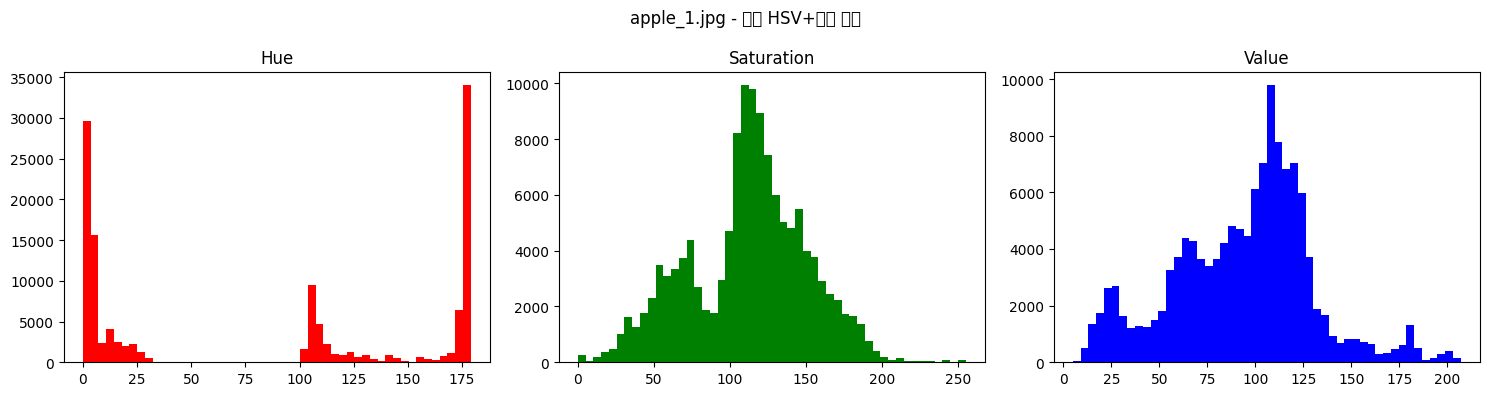

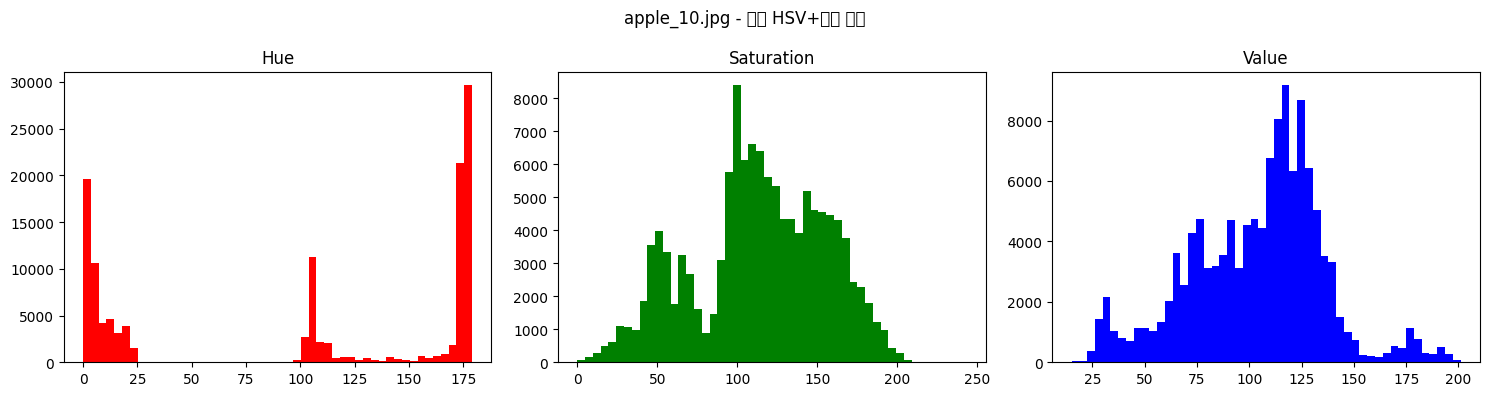

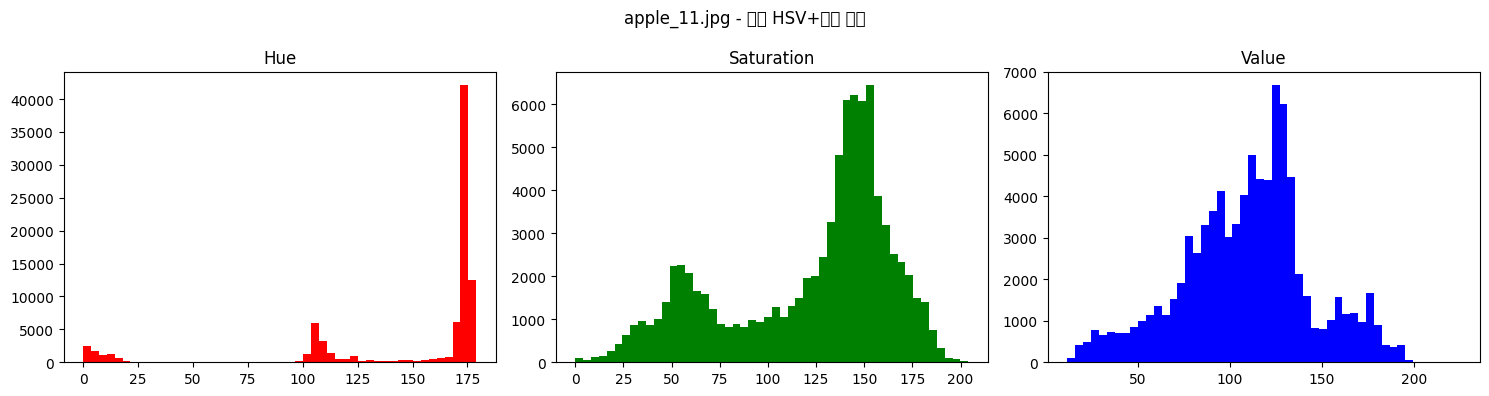

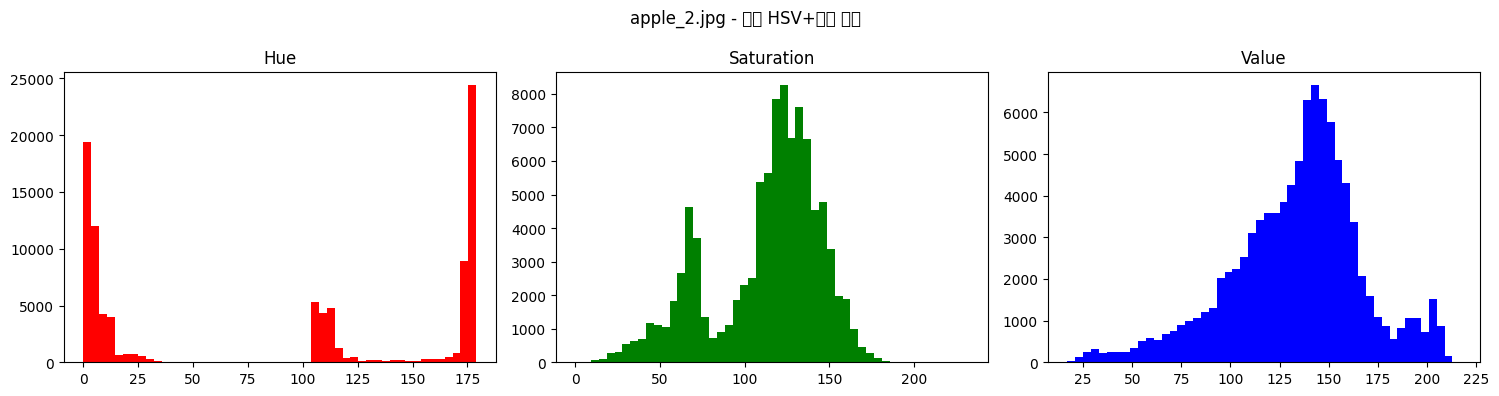

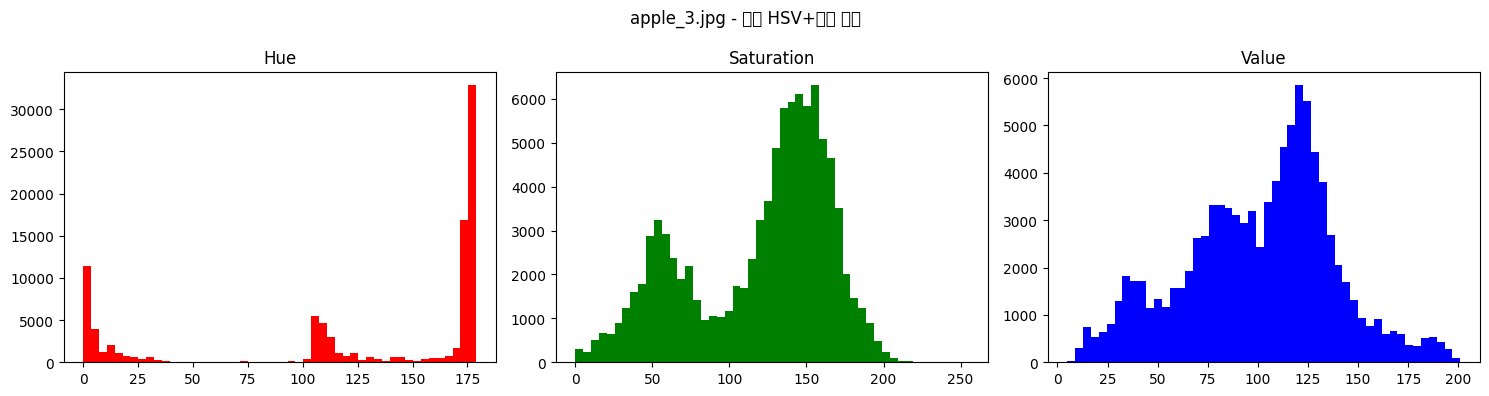

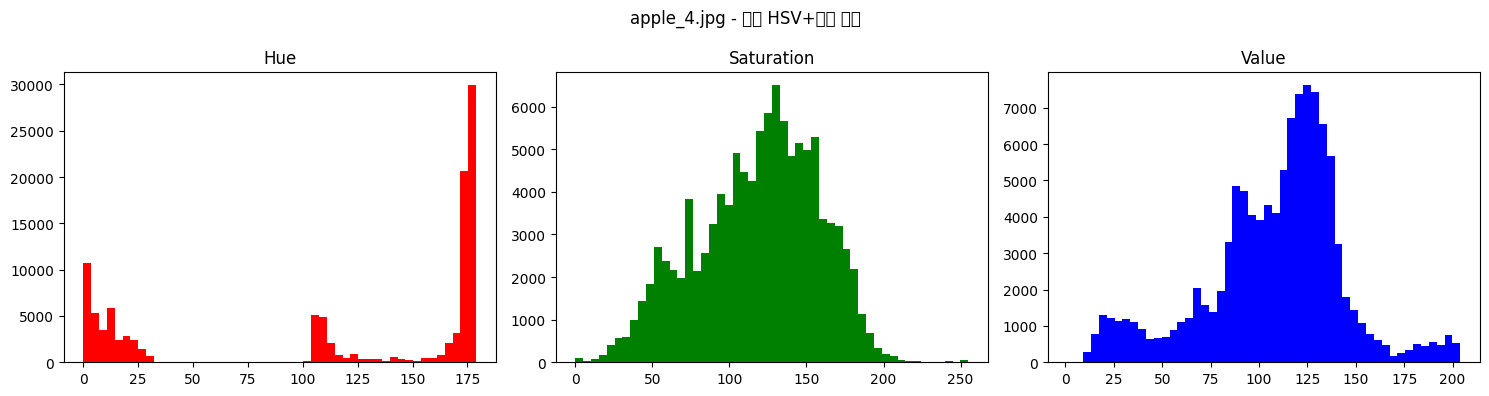

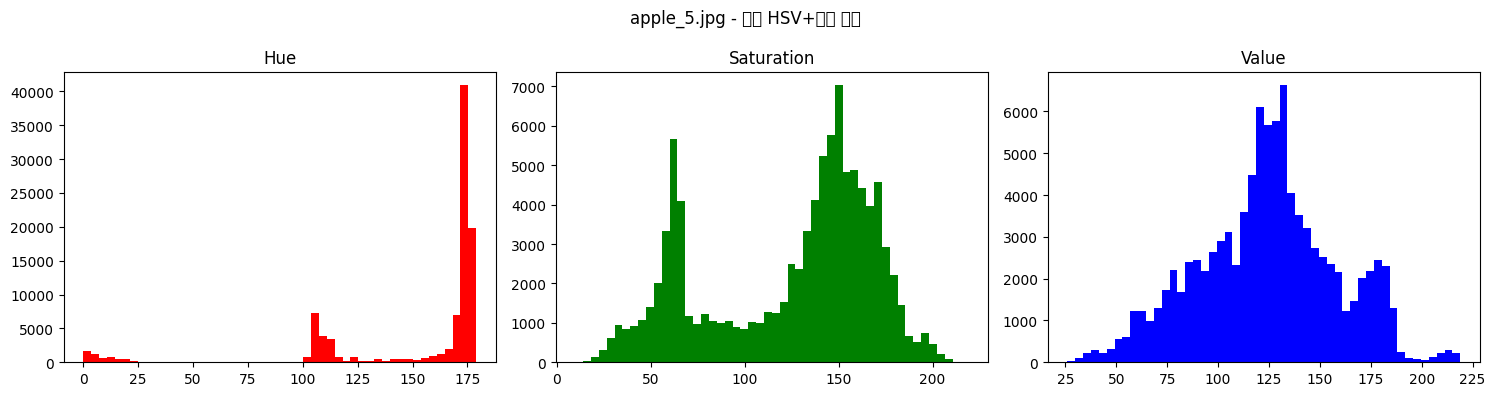

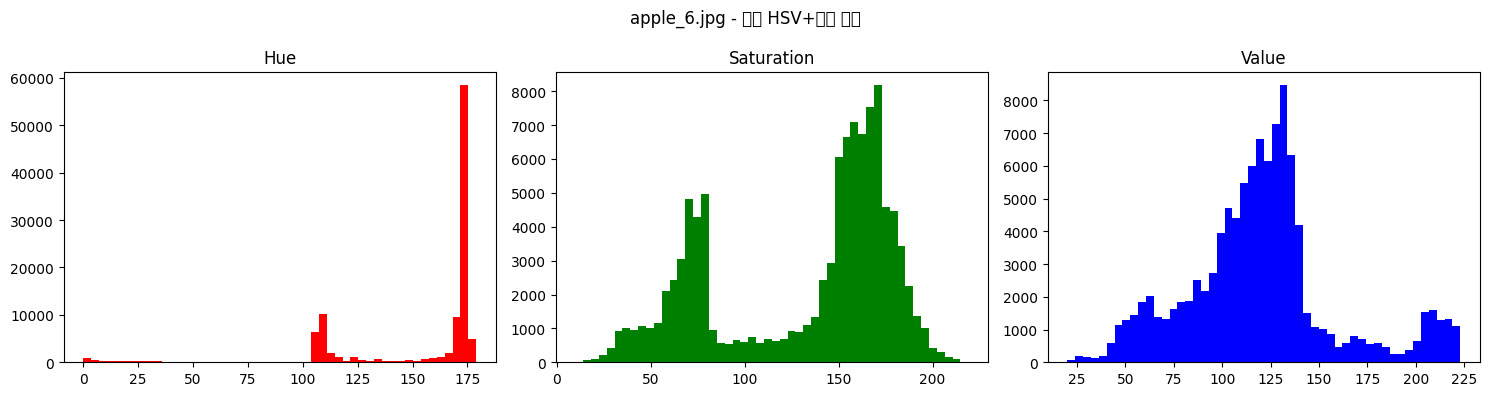

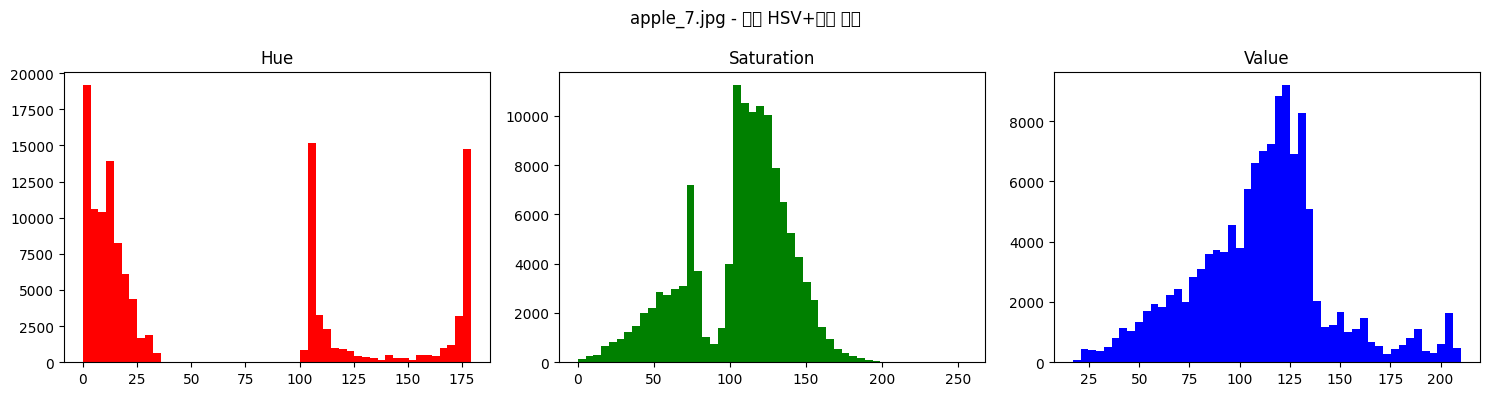

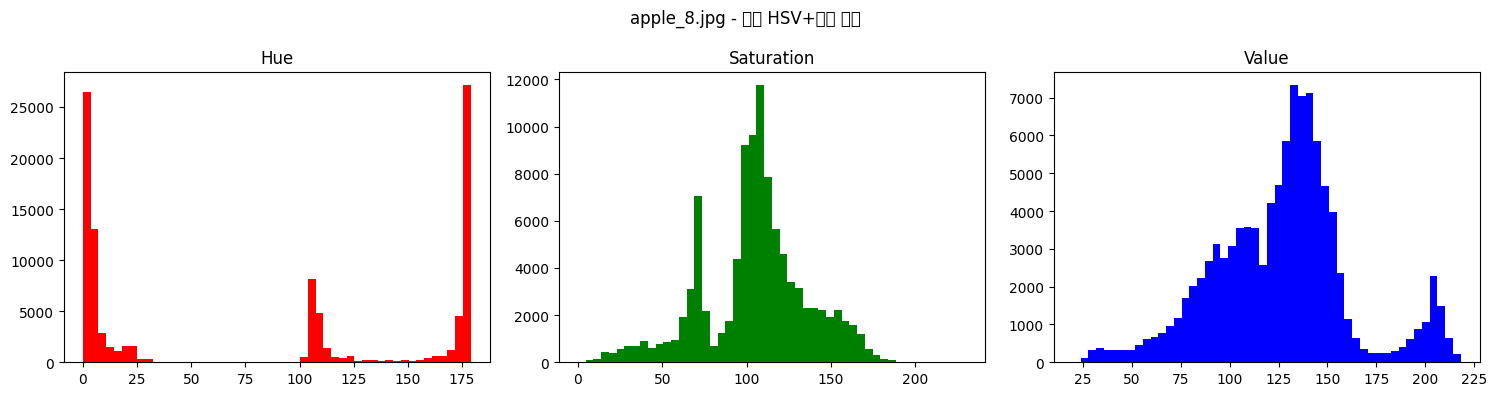

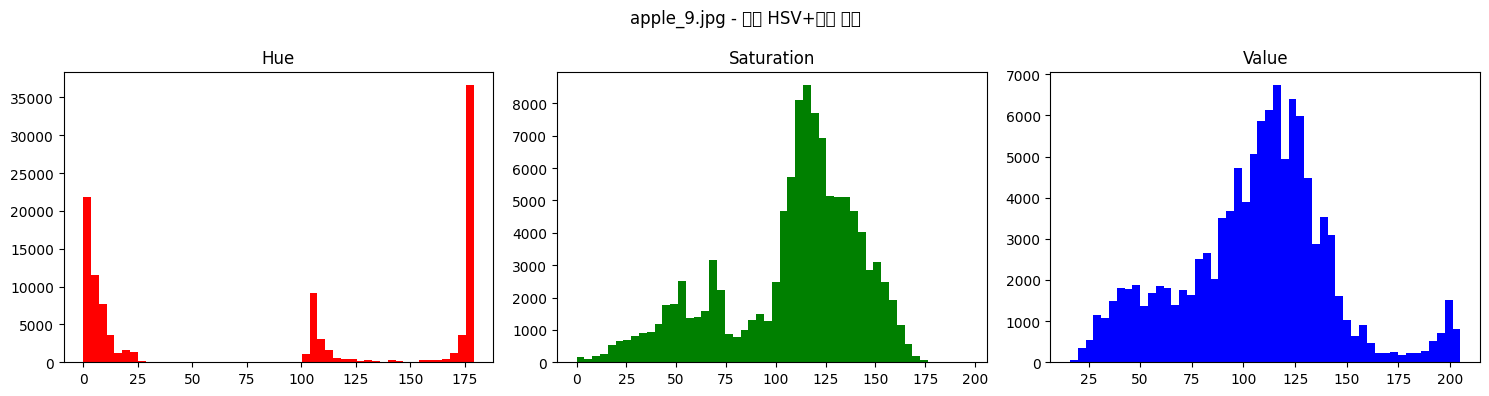

✅ 대비 포함 결함 HSV 요약 CSV 저장 완료: defect_hsv_contrast_summary.csv


In [26]:
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# ✅ 결함 통계 분석 함수 (HSV + 명도 대비 기반)
def analyze_contrast_defects_with_hsv(
    folder="C:\\Users\\kim02\\.cursor\\apple detect\\apple detect\\cnn_yolo_results\\cropped_apples", 
    defect_threshold_area=20,            # 결함으로 인정할 최소 면적
    show_plots=True,                     # 히스토그램 시각화 여부
    save_csv=True,                       # CSV 저장 여부
    csv_output_path="defect_hsv_contrast_summary.csv"  # 결과 저장 경로
):
    # ✅ 이미지 목록 로드 (지원 확장자만 필터링)
    image_files = sorted([
        f for f in os.listdir(folder) 
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ])
    summary_data = []  # 결과 요약 리스트

    for index, fname in enumerate(image_files):
        img_path = os.path.join(folder, fname)
        img = cv2.imread(img_path)

        if img is None:
            print(f"[{index}] {fname} → 이미지 로드 실패")
            continue

        # ✅ 1단계: HSV 색공간 변환 및 채널 분리
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)

        # ✅ 2단계: 결함 탐지용 마스크 생성
        dark_mask = cv2.inRange(v, 0, 70)          # 명도가 낮은 영역
        low_s_mask = cv2.inRange(s, 0, 50)         # 채도가 낮은 영역
        abnormal_h_mask = cv2.bitwise_or(
            cv2.inRange(h, 0, 10),                 # 빨간 영역
            cv2.inRange(h, 160, 180)               # 반대편 빨간 영역
        )
        abnormal_h_mask = cv2.bitwise_or(
            abnormal_h_mask,
            cv2.inRange(h, 30, 70)                 # 추가 초록-노랑 영역도 결함으로 포함
        )

        # ✅ 3단계: 대비 기반 결함 마스크 (v와 흐린 v 비교)
        blurred_v = cv2.GaussianBlur(v, (11, 11), 0)
        contrast_mask = cv2.absdiff(v, blurred_v)                 # 국소 대비 차이
        contrast_mask = cv2.inRange(contrast_mask, 30, 255)       # 높은 대비만 남김

        # ✅ 4단계: 전체 결함 마스크 통합
        defect_mask = cv2.bitwise_or(dark_mask, low_s_mask)
        defect_mask = cv2.bitwise_or(defect_mask, abnormal_h_mask)
        defect_mask = cv2.bitwise_or(defect_mask, contrast_mask)

        # ✅ 5단계: 결함 영역 탐지 (contour 기반)
        contours, _ = cv2.findContours(defect_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # ✅ 6단계: 각 결함 영역의 HSV 값 수집
        hue_vals, sat_vals, val_vals = [], [], []
        region_count = 0

        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area > defect_threshold_area:
                x, y, w, h = cv2.boundingRect(cnt)
                roi = hsv[y:y+h, x:x+w]  # 결함 영역만 잘라냄
                hue_vals.extend(roi[:, :, 0].flatten())  # H 채널
                sat_vals.extend(roi[:, :, 1].flatten())  # S 채널
                val_vals.extend(roi[:, :, 2].flatten())  # V 채널
                region_count += 1

        # ✅ 7단계: 결함 영역이 없으면 스킵
        if not hue_vals:
            print(f"[{index}] {fname} → 결함 없음 또는 무시됨")
            continue

        # ✅ 8단계: 요약 결과 저장
        summary_data.append({
            "image": fname,
            "regions_detected": region_count,
            "mean_hue": round(np.mean(hue_vals), 2),
            "mean_saturation": round(np.mean(sat_vals), 2),
            "mean_value": round(np.mean(val_vals), 2)
        })

        # ✅ 9단계: 시각화 (히스토그램)
        if show_plots:
            plt.figure(figsize=(15, 4))
            plt.suptitle(f"{fname} - 결함 HSV+대비 분포")

            plt.subplot(1, 3, 1)
            plt.hist(hue_vals, bins=50, color='red')
            plt.title("Hue")

            plt.subplot(1, 3, 2)
            plt.hist(sat_vals, bins=50, color='green')
            plt.title("Saturation")

            plt.subplot(1, 3, 3)
            plt.hist(val_vals, bins=50, color='blue')
            plt.title("Value")

            plt.tight_layout()
            plt.show()

    # ✅ 10단계: CSV 저장
    if save_csv and summary_data:
        df = pd.DataFrame(summary_data)
        df.to_csv(csv_output_path, index=False, encoding="utf-8-sig")
        print(f"✅ 대비 포함 결함 HSV 요약 CSV 저장 완료: {csv_output_path}")


# 🟢 함수 실행 (CSV 저장 및 히스토그램 표시)
analyze_contrast_defects_with_hsv()

